Supervised ML Map

In [1]:
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
    --------------------------------------- 2.1/101.7 MB 14.7 MB/s eta 0:00:07
   -- ------------------------------------- 6.3/101.7 MB 16.8 MB/s eta 0:00:06
   ---- ----------------------------------- 10.5/101.7 MB 18.2 MB/s eta 0:00:06
   ----- ---------------------------------- 14.7/101.7 MB 18.8 MB/s eta 0:00:05
   ------- -------------------------------- 17.8/101.7 MB 18.7 MB/s eta 0:00:05
   ------- -------------------------------- 19.9/101.7 MB 18.5 MB/s eta 0:00:05
   --------- ------------------------------ 24.1/101.7 MB 17.1 MB/s eta 0:00:05
   ---------- ----------------------------- 27.3/101.7 MB 16.9 MB/s eta 0:00:05
   ------------ --------------------------- 31.5/101.7 MB 17.2 MB/s eta 0:00:05
   ------------ --------------------------- 32.5/101.7 MB 16.4 MB/s eta 0:00:05
   -------------- ------------------------- 36.7/101.7 MB 16.7 MB/s eta 0:00:04
   --------------- ------------------------ 40.4/10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from sklearn.metrics import classification_report, accuracy_score

In [3]:
import catboost
from catboost import CatBoostClassifier, Pool

In [7]:
cd "C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200_2\200px_dfs"

C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200_2\200px_dfs


In [8]:
ls

 Volume in drive C has no label.
 Volume Serial Number is EAFB-235A

 Directory of C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200_2\200px_dfs

2024-09-26  11:36 AM    <DIR>          .
2024-09-26  11:37 AM    <DIR>          ..
2024-09-26  11:36 AM      (31,600,627) checker0_df.parquet
2024-09-26  11:36 AM      (31,318,194) checker1_df.parquet
2024-09-26  11:36 AM      (62,676,881) complete_df.parquet
               3 File(s)    125,595,702 bytes
               2 Dir(s)  829,753,090,048 bytes free


In [18]:
df = pd.read_parquet('checker0_df.parquet')
df.drop('geology_clipped_UNIDAD_GEN', axis=1, inplace=True)

df_test = pd.read_parquet('checker1_df.parquet')
df_test.drop('geology_clipped_UNIDAD_GEN', axis=1, inplace=True)

In [19]:
# Step 2: Check which columns are not float
non_float_columns = df.select_dtypes(exclude=['float64']).columns
print("Non-float columns:", non_float_columns)

Non-float columns: Index(['geology_clipped_SUBTIPO_DE', 'geology_clipped_GEOCHRON_1', 'TARGETS'], dtype='object')


In [20]:
target_column = 'TARGETS'

df[target_column] = (df[target_column]).astype(int)

In [21]:
df['TARGETS'].dtype

dtype('int32')

In [24]:
feature_columns = [col for col in df.columns if col != target_column]

# Updated: Identify categorical columns (object dtype or categorical)
categorical_features_indices = [i for i, col in enumerate(feature_columns)
                                if df[col].dtype == 'object' or isinstance(df[col].dtype, pd.CategoricalDtype)]

# Prepare features and target
X_train = df[feature_columns]
y_train = df[target_column]

# Handle missing values in features
# Fill missing numerical columns with 0
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train.loc[:, numerical_columns] = X_train[numerical_columns].fillna(0)

# Fill missing categorical columns with a placeholder like 'Unknown'
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train.loc[:, categorical_columns] = X_train[categorical_columns].fillna('Unknown') 

print("Unique values in the TARGETS column:", y_train.unique())

# Check if all missing values are filled
print("Number of NANs in x_train:", X_train.isnull().sum().sum())  # This should print 0



# Ensure target is binary (0 or 1)
assert set(y_train.unique()) == {0, 1}, "Target variable is not binary (0 or 1)"

# Create Pool object for training data, specifying categorical features
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Create and train the CatBoost model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    random_seed=42,
    cat_features=categorical_features_indices  # Specify categorical features here as well
)

model.fit(
    train_pool,
    verbose=200
)

# Print feature importances
feature_importances = model.get_feature_importance(prettified=True)
print("\nFeature Importances:")
print(feature_importances)

# Print categorical features
print("\nCategorical Features:")
print([feature_columns[i] for i in categorical_features_indices])

C:\Users\TyHow\AppData\Local\Temp\ipykernel_26952\1565351416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = X_train[numerical_columns].fillna(0)
C:\Users\TyHow\AppData\Local\Temp\ipykernel_26952\1565351416.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_columns] = X_train[categorical_columns].fillna('Unknown')


Unique values in the TARGETS column: [0 1]
0
0:	learn: 0.6661546	total: 329ms	remaining: 5m 28s
200:	learn: 0.3988936	total: 31.6s	remaining: 2m 5s
400:	learn: 0.3704416	total: 1m 3s	remaining: 1m 34s
600:	learn: 0.3569913	total: 1m 33s	remaining: 1m 2s
800:	learn: 0.3477826	total: 2m 3s	remaining: 30.7s
999:	learn: 0.3400046	total: 2m 33s	remaining: 0us

Feature Importances:
                                           Feature Id  Importances
0   CLIPPED_iron_oxides_indices_1340_test_larger_area    26.334341
1                          geology_clipped_SUBTIPO_DE    20.283863
2   CLIPPED_clay_minerals_indices_1340_test_larger...    13.364199
3                          geology_clipped_GEOCHRON_1    12.387246
4   CLIPPED_phosphorus_apatite_indices_1340_test_l...    11.504000
5        CLIPPED_gypsum_indices_1340_test_larger_area     8.229466
6   CLIPPED_illite_s2_copper_sam_1340_test_larger_...     2.552053
7   CLIPPED_muscovite_s2_copper_sam_1340_test_larg...     1.631595
8   CLIPPED_magnet

#### Test Dataset

In [27]:
# Load your test data from the Parquet file
df_test[target_column] = (df_test[target_column]).astype(int)


# Ensure the feature columns match those used in training
feature_columns = model.feature_names_

# Prepare features and target for testing
X_test = df_test[feature_columns]
y_test = df_test[target_column]

# Handle missing values in the test set (similar to what you did with the training data)
X_test.loc[:, numerical_columns] = X_test[numerical_columns].fillna(0)
X_test.loc[:, categorical_columns] = X_test[categorical_columns].fillna('Unknown')

# Check for any remaining missing values in X_test and y_test
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in y_test: {y_test.isnull().sum()}")


# Check if there's only one class in y_test
unique_classes = np.unique(y_test)
if len(unique_classes) == 1:
    print(f"Warning: Only one class present in the test set: {unique_classes[0]}")
    single_class = unique_classes[0]
else:
    single_class = None

# Identify categorical features (should match the training data)
categorical_features_indices = model.get_cat_feature_indices()

# Create test pool
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# Make predictions
y_pred = model.predict(test_pool)

# Calculate and print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Missing values in X_test: 0
Missing values in y_test: 0
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88    876042
           1       0.07      0.22      0.11     53958

    accuracy                           0.79    930000
   macro avg       0.51      0.52      0.50    930000
weighted avg       0.89      0.79      0.84    930000

Accuracy: 0.7945


## Trying to fit the entire dataset through

In [32]:
def get_proba_map(X_df, model, map_shape):
    """
    Generates a probability map from input features using a trained model.

    Parameters:
    X_df (pd.DataFrame): A DataFrame containing the input features for prediction.
    model (CatBoostClassifier): A trained CatBoost model.
    map_shape (tuple): The desired shape of the output map (height, width).

    Returns:
    np.ndarray: A 2D array with the shape specified by map_shape, containing the predicted probabilities for each pixel.
    """
    # Handle missing values before creating the Pool
    # Fill missing numerical columns with 0
    numerical_columns = X_df.select_dtypes(include=['float64', 'int64']).columns
    X_df[numerical_columns] = X_df[numerical_columns].fillna(0)

    # Fill missing categorical columns with a placeholder like 'Unknown'
    categorical_columns = X_df.select_dtypes(include=['object']).columns
    X_df[categorical_columns] = X_df[categorical_columns].fillna('Unknown')

    # Identify string columns as categorical features
    cat_features = X_df.select_dtypes(include=['object']).columns.tolist()

    # Create a Pool object for CatBoost
    pool = Pool(X_df, cat_features=cat_features)

    # Get predictions from the model (probability of the positive class)
    predictions = model.predict_proba(pool)[:, 1]

    # Ensure the predictions can be reshaped into the desired map shape
    expected_size = map_shape[0] * map_shape[1]
    if len(predictions) != expected_size:
        raise ValueError(f"Prediction size ({len(predictions)}) does not match the expected size ({expected_size}).")

    # Reshape the predictions to the desired map shape
    pred_ar = predictions.reshape(map_shape)

    return pred_ar


In [29]:
df_complete = pd.read_parquet('complete_df.parquet')

In [30]:

df_selected = df_complete

In [33]:
# Determine the map shape
# You need to specify the correct shape here. For example:
map_height = 1550  # Replace with the actual height of your map
map_width = 1200   # Replace with the actual width of your map
map_shape = (map_height, map_width)

# Generate probability map
prob_map = get_proba_map(df_selected, model, map_shape)

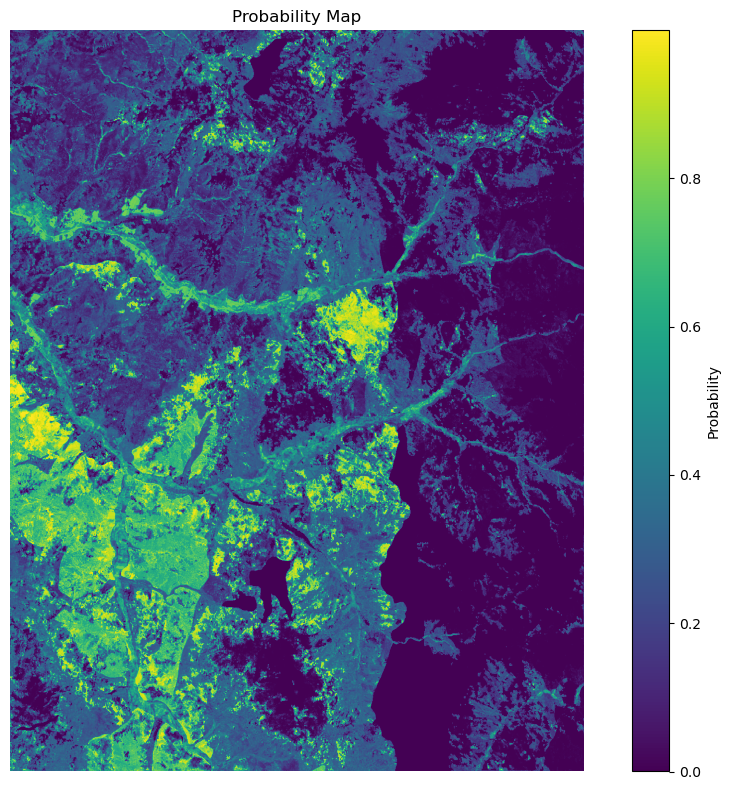

In [34]:
# Plot the probability map
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='viridis')
plt.colorbar(label='Probability')
plt.title('Probability Map')
plt.axis('off')
plt.tight_layout()
plt.show()